In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df_ldap = pd.read_csv("LDAP/LDAP_level3.csv")

In [3]:
df_mssql = pd.read_csv("MSSQL/MSSQL_level3.csv")

In [4]:
df_netbios = pd.read_csv("Netbios/Netbios_level3.csv")

In [5]:
df_ntp = pd.read_csv("NTP/NTP_level3.csv")

In [6]:
df_snmp = pd.read_csv("SNMP/SNMP_level3.csv")

In [7]:
df_ssdp = pd.read_csv("SSDP/SSDP_level3.csv")

In [8]:
df_tftp = pd.read_csv("TFTP/TFTP_level3.csv")

In [9]:
df_port = pd.read_csv("Portmap/Portmap_level3.csv")

In [10]:
df_dns = pd.read_csv("DNS/DNS_level3.csv")

In [11]:
df_final = pd.concat([df_dns, 
                     df_ldap,
                     df_mssql,
                     df_netbios,
                     df_ntp,
                     df_snmp,
                     df_ssdp,
                    # df_udp,
                     #df_syn,
                     df_tftp,
                     #df_udplag,
                     df_port])

In [12]:
df_final.shape

(180000, 68)

In [13]:
df_final_counts = df_final.groupby(' Label')[' Label'].count().reset_index(name="count")

In [14]:
df_final_counts

,Label,count
0,DrDoS_DNS,12000
1,DrDoS_MSSQL,30000
2,DrDoS_NTP,30000
3,DrDoS_SNMP,12000
4,DrDoS_SSDP,30000
5,LDAP,12000
6,NetBIOS,12000
7,Portmap,12000
8,TFTP,30000


In [15]:
data_classes = list(df_final[' Label'].unique())

In [16]:
data_classes

['DrDoS_DNS',
 'LDAP',
 'DrDoS_MSSQL',
 'NetBIOS',
 'DrDoS_NTP',
 'DrDoS_SNMP',
 'DrDoS_SSDP',
 'TFTP',
 'Portmap']

In [17]:
df_final[' Label'] = df_final[' Label'].apply(data_classes.index)

In [18]:
df_final[' Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [40]:
X = df_final.drop(' Label', axis = 1)

In [20]:
y = df_final[' Label'].values

In [21]:
for i in range(len(y)):
    if y[i] == 2 or y[i] == 6:
        y[i] = 0
    elif y[i] == 7 or y[i] == 4:
        y[i] = 1
    else:
        y[i] = 2

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

anova_features = SelectKBest(f_classif)

In [23]:
k_best_features_anova = anova_features.fit_transform(X, y)

In [41]:
for i in range(len(anova_features.scores_)):
    if anova_features.scores_[i] > 25000:
        print(X.columns[i], ":", anova_features.scores_[i])

 Source Port : 75005.39443585304
 Fwd Packet Length Max : 30086.016420721568
 Fwd Packet Length Min : 32853.22145734091
 Fwd Packet Length Mean : 30755.853853985358
Fwd Packets/s : 26563.884369669235
 Min Packet Length : 32852.958714083514
 Max Packet Length : 30064.769129587432
 Packet Length Mean : 30777.391268981195
 Average Packet Size : 37748.4229716487
 Avg Fwd Segment Size : 30755.853853985358


In [42]:
X = df_final[[' Source Port',
            #' Protocol',
           #'Total Length of Fwd Packets',
            ' Fwd Packet Length Mean',
            ' Fwd Packet Length Max',
            ' Fwd Packet Length Min',
            'Fwd Packets/s',
            ' Min Packet Length',
            ' Max Packet Length',
            ' Packet Length Mean',
            #' ACK Flag Count',
            #' Down/Up Ratio',
            ' Average Packet Size',
            ' Avg Fwd Segment Size']].values

In [43]:
X.shape

(180000, 10)

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
scaler = RobustScaler()

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, shuffle = True)

In [46]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors = 7)
classifier_knn.fit(X_train, y_train)

In [31]:
pred_knn = classifier_knn.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       0.99      1.00      1.00     15000
           2       0.99      1.00      0.99     15000

    accuracy                           0.99     45000
   macro avg       0.99      0.99      0.99     45000
weighted avg       0.99      0.99      0.99     45000



<AxesSubplot:>

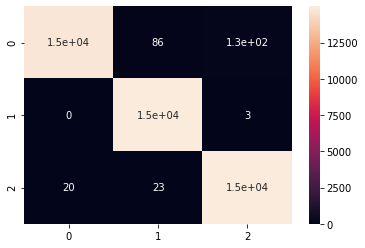

In [32]:
import seaborn as sns
cm = confusion_matrix(y_test, pred_knn)
sns.heatmap(cm, annot = True)

In [33]:
from sklearn.tree import DecisionTreeClassifier

classifier_tree = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best')
classifier_tree.fit(X_train, y_train)

pred_tree = classifier_tree.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       1.00      1.00      1.00     15000
           2       0.99      1.00      0.99     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



<AxesSubplot:>

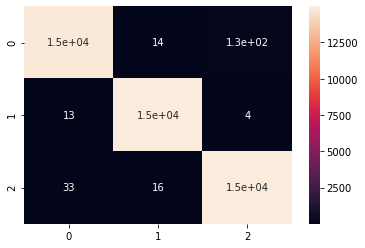

In [34]:
cm = confusion_matrix(y_test, pred_tree)
sns.heatmap(cm, annot = True)

In [35]:
from sklearn.ensemble import RandomForestClassifier

classifier_forest = RandomForestClassifier(criterion = 'entropy')
classifier_forest.fit(X_train, y_train)
pred_forest = classifier_forest.predict(X_test)
print(classification_report(y_test, pred_forest))

/Users/onkarthorat/opt/anaconda3/envs/final/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       1.00      1.00      1.00     15000
           2       0.99      1.00      0.99     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



<AxesSubplot:>

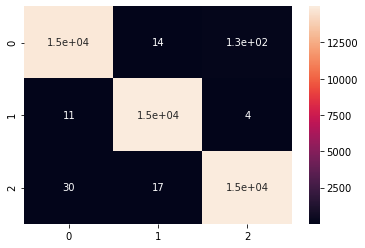

In [36]:
cm = confusion_matrix(y_test, pred_forest)
sns.heatmap(cm, annot = True)

In [37]:
from sklearn.ensemble import VotingClassifier

classifier_ensemble = VotingClassifier(estimators = [('knn', classifier_knn), ('dt', classifier_tree)], 
                                      voting = 'hard')
classifier_ensemble.fit(X_train, y_train)
pred_ensemble = classifier_ensemble.predict(X_test)


In [38]:
print(classification_report(y_test, pred_ensemble))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15000
           1       1.00      1.00      1.00     15000
           2       0.99      1.00      0.99     15000

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



<AxesSubplot:>

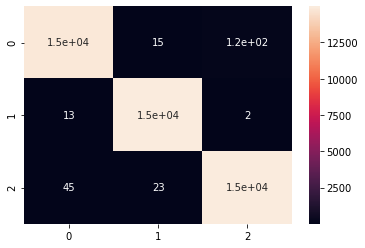

In [39]:
cm = confusion_matrix(y_test, pred_ensemble)
sns.heatmap(cm, annot = True)